In [326]:
import pandas as pd
import os 
current_dir = os.getcwd()
from sklearn.preprocessing import StandardScaler

In [327]:
pd.set_option('display.max_columns', None)
current_dir = os.getcwd()

#### Leer solo la columna de fechas primero

In [328]:
total_data_path = os.path.join(current_dir, '../data/raw/total_data.csv')

fechas = pd.read_csv(total_data_path, usecols=["date"])

#### Ver cuántas fechas únicas hay

In [329]:
fechas_unicas = fechas["date"].nunique()
print(f"Fechas únicas: {fechas_unicas}")

Fechas únicas: 1941


####  Leer por chunks y seleccionar 500 filas por fecha

In [330]:

output = []

# Primero descubrimos qué columnas tiene (para leer todo después por partes)
columnas = pd.read_csv(total_data_path, nrows = 1).columns

# Creamos un diccionario para contar cuántas filas hemos tomado por fecha
cuenta_fechas = {}

# Queremos 1 millón de filas
meta_total = 1_000_000
chunk_size = 100_000
total_actual = 0

for chunk in pd.read_csv(total_data_path, chunksize = chunk_size):
    for fecha, grupo in chunk.groupby("date"):
        if cuenta_fechas.get(fecha, 0) < 500:
            faltan = 500 - cuenta_fechas.get(fecha, 0)
            seleccion = grupo.sample(n = min(faltan, len(grupo)), random_state = 77)
            output.append(seleccion)
            cuenta_fechas[fecha] = cuenta_fechas.get(fecha, 0) + len(seleccion)
            total_actual += len(seleccion)
            
            if total_actual >= meta_total:
                break
    if total_actual >= meta_total:
        break

C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1973051828.py:14: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize = chunk_size):
C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1973051828.py:14: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize = chunk_size):
C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1973051828.py:14: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize = chunk_size):
C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1973051828.py:14: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize = chunk_size):
C:\Users\andta\AppData\Local\Temp\ipyker

#### Concatenar y guardar en csv (1 Millon de filas)

In [331]:
final_data = pd.concat(output)

final_data_path = os.path.join(current_dir, '../data/raw/final_data.csv')

final_data.to_csv(final_data_path, index=False)

In [332]:
final_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
3573,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3529,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
24983,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,5.36
20557,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4070,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


#### Revision columnas

In [333]:
print(final_data.id.nunique())
print(final_data.id.isnull().sum())
print(final_data.id.dtype)

26670
0
object


In [334]:
with open("resumen_columnas.txt", "w") as f:
    for col in final_data.columns:
        unicos = final_data[col].nunique()
        nulos = final_data[col].isnull().sum()
        tipo = final_data[col].dtype

        f.write(f"Columna: {col}\n")
        f.write(f"  Valores únicos: {unicos}\n")
        f.write(f"  Valores nulos: {nulos}\n")
        f.write(f"  Tipo de dato: {tipo}\n")
        f.write("\n")


### Procesamiento de los datos

#### Preprocesamiento de la columna `date`

In [335]:
# Convertir la columna 'date' a formato datetime
final_data['date'] = pd.to_datetime(final_data['date'])

# Extraer características de la fecha
final_data['day_of_week'] = final_data['date'].dt.dayofweek  # Día de la semana (0 = lunes, 6 = domingo)
final_data['is_weekend'] = final_data['day_of_week'].isin([5, 6]).astype(int)  # Fin de semana (1 = sí, 0 = no)
final_data['month'] = final_data['date'].dt.month  # Mes
final_data['quarter'] = final_data['date'].dt.quarter  # Trimestre


### Procesamiento de valores nulos

In [336]:
# Rellenar valores nulos con 0 o con el valor medio de la columna
final_data['event_name_1'].fillna('No Event', inplace=True)
final_data['event_type_1'].fillna('No Type', inplace=True)
final_data['event_name_2'].fillna('No Event', inplace=True) 
final_data['event_type_2'].fillna('No Type', inplace=True)

C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1541185424.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_data['event_name_1'].fillna('No Event', inplace=True)
C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1541185424.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [337]:
# Rellenar valores nulos en 'sell_price' con el último valor conocido para cada item_id y store_id
final_data['sell_price'] = final_data.groupby(['item_id', 'store_id'])['sell_price'].ffill()

# Verificamos que no haya más valores nulos
print(final_data['sell_price'].isnull().sum())



198189


In [338]:
# Rellenar valores nulos en 'sell_price' con el siguiente valor conocido para cada item_id y store_id
final_data['sell_price'] = final_data.groupby(['item_id', 'store_id'])['sell_price'].bfill()

# Verificamos que no haya más valores nulos
print(final_data['sell_price'].isnull().sum())


2855


In [339]:
# Rellenar los valores nulos restantes con la media de sell_price
mean_sell_price = final_data['sell_price'].mean()
final_data['sell_price'].fillna(mean_sell_price, inplace=True)

# Verificamos que no haya más valores nulos
print(final_data['sell_price'].isnull().sum())


0


C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1176023560.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_data['sell_price'].fillna(mean_sell_price, inplace=True)


### Escalar la variable `sell_price`

In [340]:
scaler = StandardScaler()
final_data['scaled_sell_price'] = scaler.fit_transform(final_data[['sell_price']])

In [341]:
final_data.date.min()

Timestamp('2011-01-29 00:00:00')

In [342]:
final_data.date.max()

Timestamp('2016-05-22 00:00:00')

In [343]:
final_data.state_id.value_counts()

state_id
CA    496057
TX    256552
WI    217891
Name: count, dtype: int64

### Unificando Macrodatos con final_data

In [344]:
personal_income_path = os.path.join(current_dir, "../data/raw/macrodata/personal_income.csv")
population_density_path = os.path.join(current_dir, "../data/raw/macrodata/population_density.csv")
population_growth_path = os.path.join(current_dir, "../data/raw/macrodata/population_growth.csv")
riqueza_per_capita_path = os.path.join(current_dir, "../data/raw/macrodata/riqueza_per_capita.csv")
wti_crude_oil_path = os.path.join(current_dir, "../data/raw/macrodata/wti_crude_oil.csv")

personal_income = pd.read_csv(personal_income_path)
population_density = pd.read_csv(population_density_path)
population_growth = pd.read_csv(population_growth_path)
riqueza_per_capita = pd.read_csv(riqueza_per_capita_path)
wti_crude_oil = pd.read_csv(wti_crude_oil_path)

In [345]:
final_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price
3573,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920
3529,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161
24983,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923
20557,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813
4070,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59168880,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816
59167909,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587
59174004,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690
59160113,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066


#### Merge de final_data con personal_income

In [346]:
personal_income

,State,pi_mean_2011,pi_mean_2012,pi_mean_2013,pi_mean_2014,pi_mean_2015,pi_mean_2016
0,CA,2.954186e+07,3.128902e+07,3.173940e+07,3.371928e+07,3.615603e+07,3.777824e+07
1,TX,4.231724e+06,4.499557e+06,4.621053e+06,4.951337e+06,5.043977e+06,5.024924e+06
2,WI,3.330011e+06,3.470573e+06,3.488184e+06,3.621579e+06,3.777543e+06,3.844672e+06


In [347]:
# 1. Convertir personal_income a formato largo
income_long = personal_income.melt(id_vars='State', 
                                    var_name='year', 
                                    value_name='pi_mean')
# 2. Limpiar la columna 'year' para que sea un entero
income_long['year'] = income_long['year'].str.extract(r'(\d{4})').astype(int)

# 3. Renombrar 'State' a 'state_id' para evitar duplicados
income_long.rename(columns={'State': 'state_id'}, inplace=True)

# 4. Merge
final_data = final_data.merge(income_long, on=['state_id', 'year'], how='left')
final_data


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price,pi_mean
0,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920,2.954186e+07
1,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161,2.954186e+07
2,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923,3.330011e+06
3,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813,4.231724e+06
4,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214,2.954186e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970495,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816,5.024924e+06
970496,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587,5.024924e+06
970497,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690,3.844672e+06
970498,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066,3.777824e+07


#### Merge de final_data con population_density

In [348]:
population_density

,State,poblacion_2011,poblacion_2012,poblacion_2013,poblacion_2014,poblacion_2015,poblacion_2016
0,CA,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0
1,TX,25645629.0,26084481.0,26480266.0,26964333.0,27470056.0,27914410.0
2,WI,5705288.0,5719960.0,5736754.0,5751525.0,5760940.0,5772628.0


In [349]:
# 1. Convertir population_density a formato largo
population_den_long = population_density.melt(id_vars='State', 
                                    var_name='year', 
                                    value_name='poblacion')
# 2. Limpiar la columna 'year' para que sea un entero
population_den_long['year'] = population_den_long['year'].str.extract(r'(\d{4})').astype(int)

# 3. Renombrar 'State' a 'state_id' para evitar duplicados
population_den_long.rename(columns={'State': 'state_id'}, inplace=True)

# 4. Merge
final_data = final_data.merge(population_den_long, on=['state_id', 'year'], how='left')
final_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price,pi_mean,poblacion
0,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920,2.954186e+07,37638369.0
1,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161,2.954186e+07,37638369.0
2,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923,3.330011e+06,5705288.0
3,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813,4.231724e+06,25645629.0
4,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214,2.954186e+07,37638369.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970495,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816,5.024924e+06,27914410.0
970496,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587,5.024924e+06,27914410.0
970497,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690,3.844672e+06,5772628.0
970498,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066,3.777824e+07,39167117.0


#### Merge de final_data con population_growth

In [350]:
population_growth

,State,Crecimiento_p_2011,Crecimiento_p_2012,Crecimiento_p_2013,Crecimiento_p_2014,Crecimiento_p_2015,Crecimiento_p_2016
0,CA,0.82,0.82,0.88,0.83,0.64,0.49
1,TX,1.71,1.52,1.83,1.88,1.62,1.36
2,WI,0.26,0.29,0.26,0.16,0.20,0.30


In [351]:
# 1. Convertir population_growth a formato largo
population_growth_long = population_growth.melt(id_vars='State', 
                                    var_name='year', 
                                    value_name='Crecimiento_p')
# 2. Limpiar la columna 'year' para que sea un entero
population_growth_long['year'] = population_growth_long['year'].str.extract(r'(\d{4})').astype(int)

# 3. Renombrar 'State' a 'state_id' para evitar duplicados
population_growth_long.rename(columns={'State': 'state_id'}, inplace=True)

# 4. Merge
final_data = final_data.merge(population_growth_long, on=['state_id', 'year'], how='left')
final_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price,pi_mean,poblacion,Crecimiento_p
0,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920,2.954186e+07,37638369.0,0.82
1,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161,2.954186e+07,37638369.0,0.82
2,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923,3.330011e+06,5705288.0,0.26
3,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813,4.231724e+06,25645629.0,1.71
4,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214,2.954186e+07,37638369.0,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970495,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816,5.024924e+06,27914410.0,1.36
970496,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587,5.024924e+06,27914410.0,1.36
970497,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690,3.844672e+06,5772628.0,0.30
970498,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066,3.777824e+07,39167117.0,0.49


In [352]:
final_data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_of_week',
       'is_weekend', 'quarter', 'scaled_sell_price', 'pi_mean', 'poblacion',
       'Crecimiento_p'],
      dtype='object')

#### Merge de final_data con riqueza_per_capita

In [353]:
riqueza_per_capita = riqueza_per_capita[riqueza_per_capita["GeoName"].isin(["California","Texas", "Wisconsin"])]
riqueza_per_capita

# Diccionario de nombres a siglas
state_abbrev = {
    "California": "CA",
    "Texas": "TX",
    "Wisconsin": "WI"
}
riqueza_per_capita["GeoName"] = riqueza_per_capita["GeoName"].str.strip()
riqueza_per_capita['GeoName'] = riqueza_per_capita['GeoName'].map(state_abbrev)



Formateo la tabla de riqueza_per_capita para que tenga las columnas que nos interesan

In [354]:

# 1. Transforma de ancho a largo
riqueza_per_capita_long = riqueza_per_capita.melt(id_vars='GeoName', var_name='month_year', value_name='riqueza_per_capita')
# 2. Extraer el mes y el año
riqueza_per_capita_long[['month', 'year']] = riqueza_per_capita_long['month_year'].str.extract(r'(\w+)_([0-9]{4})')

# 3. Traduce los nombres de los meses a números
meses = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
    'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}
riqueza_per_capita_long['month'] = riqueza_per_capita_long['month'].map(meses).astype(int)
riqueza_per_capita_long['year'] = riqueza_per_capita_long['year'].astype(int)

# 4. Eliminar columnas
riqueza_per_capita_long = riqueza_per_capita_long.drop(columns=['month_year'])
riqueza_per_capita_long


,GeoName,riqueza_per_capita,month,year
0,CA,15065.000000,1,2011
1,TX,13775.000000,1,2011
2,WI,13536.666667,1,2011
3,CA,15065.000000,2,2011
4,TX,13775.000000,2,2011
...,...,...,...,...
211,TX,15472.333333,11,2016
212,WI,15623.666667,11,2016
213,CA,18884.333333,12,2016
214,TX,15472.333333,12,2016


In [355]:
# 5. Renombrar 'State' a 'state_id' para evitar duplicados
riqueza_per_capita_long.rename(columns={'GeoName': 'state_id'}, inplace=True)

# 6. Merge
final_data = final_data.merge(riqueza_per_capita_long, on=['state_id', 'year', 'month'], how='left')
final_data



,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price,pi_mean,poblacion,Crecimiento_p,riqueza_per_capita
0,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920,2.954186e+07,37638369.0,0.82,15065.000000
1,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161,2.954186e+07,37638369.0,0.82,15065.000000
2,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923,3.330011e+06,5705288.0,0.26,13536.666667
3,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813,4.231724e+06,25645629.0,1.71,13775.000000
4,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214,2.954186e+07,37638369.0,0.82,15065.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970495,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816,5.024924e+06,27914410.0,1.36,15185.000000
970496,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587,5.024924e+06,27914410.0,1.36,15185.000000
970497,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690,3.844672e+06,5772628.0,0.30,15459.333333
970498,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,5,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066,3.777824e+07,39167117.0,0.49,18491.000000


In [356]:
final_data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_of_week',
       'is_weekend', 'quarter', 'scaled_sell_price', 'pi_mean', 'poblacion',
       'Crecimiento_p', 'riqueza_per_capita'],
      dtype='object')

#### Merge de final_data con wti_crude_oil

In [357]:
wti_crude_oil


,Date,Open,High,Low,Close,Adj Close,Volume
0,"May 20, 2016",2.0600,2.18,2.05,2.16,2.1022,"1,297,800"
1,"May 19, 2016",2.0800,2.08,1.98,2.02,1.9659,"1,647,700"
2,"May 18, 2016",2.1800,2.19,2.08,2.09,2.0340,"1,419,300"
3,"May 17, 2016",2.1800,2.25,2.14,2.15,2.0924,"1,268,300"
4,"May 16, 2016",2.2800,2.32,2.08,2.15,2.0924,"2,523,400"
...,...,...,...,...,...,...,...
1349,"Feb 4, 2011",21.0200,21.09,20.53,21.02,17.2893,"491,400"
1350,"Feb 3, 2011",20.6400,21.09,20.33,20.94,17.2235,"374,600"
1351,"Feb 2, 2011",20.6000,21.13,20.55,20.61,16.9521,"488,600"
1352,"Feb 1, 2011",20.5700,21.33,20.40,20.67,17.0014,"1,106,600"


In [358]:
wti_oil = wti_crude_oil[["Date", "Close"]]
wti_oil

,Date,Close
0,"May 20, 2016",2.16
1,"May 19, 2016",2.02
2,"May 18, 2016",2.09
3,"May 17, 2016",2.15
4,"May 16, 2016",2.15
...,...,...
1349,"Feb 4, 2011",21.02
1350,"Feb 3, 2011",20.94
1351,"Feb 2, 2011",20.61
1352,"Feb 1, 2011",20.67


In [359]:
final_data['date']

0        2011-01-29
1        2011-01-29
2        2011-01-29
3        2011-01-29
4        2011-01-29
            ...    
970495   2016-05-22
970496   2016-05-22
970497   2016-05-22
970498   2016-05-22
970499   2016-05-22
Name: date, Length: 970500, dtype: datetime64[ns]

#### Convertir a Datetime

In [360]:
# Conversión a datetime
wti_oil["Date"] = pd.to_datetime(wti_oil["Date"], format='%b %d, %Y')
final_data["date"] = pd.to_datetime(final_data['date'])
wti_oil

C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1698335354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil["Date"] = pd.to_datetime(wti_oil["Date"], format='%b %d, %Y')


,Date,Close
0,2016-05-20,2.16
1,2016-05-19,2.02
2,2016-05-18,2.09
3,2016-05-17,2.15
4,2016-05-16,2.15
...,...,...
1349,2011-02-04,21.02
1350,2011-02-03,20.94
1351,2011-02-02,20.61
1352,2011-02-01,20.67


In [361]:
wti_oil.rename(columns = {"Date" : "date"}, inplace = True)

C:\Users\andta\AppData\Local\Temp\ipykernel_7732\3332692542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil.rename(columns = {"Date" : "date"}, inplace = True)


Merge - Pero hay valores nulos porque en el Web Scraping no nos salen todos los dias y decidimos utilizar la media mensual en los valores nulos

In [362]:
# Join
final_data = final_data.merge(wti_oil, on="date", how="outer")

final_data["Close"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 979500 entries, 0 to 979499
Series name: Close
Non-Null Count   Dtype  
--------------   -----  
668000 non-null  float64
dtypes: float64(1)
memory usage: 7.5 MB


Obtener media mensual

In [363]:
# Crear una nueva columna de mes (tipo Periodo mensual)
wti_oil["month"] = wti_oil["date"].dt.to_period("M")
# Por cada mes obtener la media del precio del wti
media_mensual = wti_oil.groupby("month")["Close"].mean()

C:\Users\andta\AppData\Local\Temp\ipykernel_7732\1872059049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil["month"] = wti_oil["date"].dt.to_period("M")


Crear WTI en sales

In [364]:
final_data["date"] = pd.to_datetime(final_data["date"])
# Crear una columna de mes (tipo Periodo mensual) en 'sales'
final_data["month"] = final_data["date"].dt.to_period("M")
# Rellenar valor nan por media del mes obtenido anteriormente

# Creo un diccionario
media_mensual_dict = media_mensual.to_dict()


# Rellenar los NaN de 'wti' con la media del mes correspondiente
final_data["Close"] = final_data["Close"].fillna(final_data["month"].map(media_mensual_dict))
final_data["Close"].info()

# Encontramos valores Nan en las fechas, que venían del principio al extraer los datos de sales.csv
# Eliminarlos en el Análisis descriptivo
final_data[final_data["Close"].isna()]["date"]

# Columna WTI renombrada
final_data.rename(columns = {"Close" : "wti"}, inplace=True)

<class 'pandas.core.series.Series'>
RangeIndex: 979500 entries, 0 to 979499
Series name: Close
Non-Null Count   Dtype  
--------------   -----  
979500 non-null  float64
dtypes: float64(1)
memory usage: 7.5 MB


In [365]:
final_data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_of_week',
       'is_weekend', 'quarter', 'scaled_sell_price', 'pi_mean', 'poblacion',
       'Crecimiento_p', 'riqueza_per_capita', 'wti'],
      dtype='object')

In [366]:
final_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,quarter,scaled_sell_price,pi_mean,poblacion,Crecimiento_p,riqueza_per_capita,wti
0,HOBBIES_2_109_CA_2_evaluation,HOBBIES_2_109,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,2011-01,2011,No Event,No Type,No Event,No Type,0,0,0,0.97,5,1,1,-0.994920,2.954186e+07,37638369.0,0.82,15065.000000,20.350000
1,HOBBIES_2_065_CA_2_evaluation,HOBBIES_2_065,HOBBIES_2,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,2011-01,2011,No Event,No Type,No Event,No Type,0,0,0,0.50,5,1,1,-1.126161,2.954186e+07,37638369.0,0.82,15065.000000,20.350000
2,HOUSEHOLD_1_027_WI_2_evaluation,HOUSEHOLD_1_027,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,2011-01,2011,No Event,No Type,No Event,No Type,0,0,0,5.36,5,1,1,0.230923,3.330011e+06,5705288.0,0.26,13536.666667,20.350000
3,FOODS_3_038_TX_3_evaluation,FOODS_3_038,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,2011-01,2011,No Event,No Type,No Event,No Type,0,0,0,4.98,5,1,1,0.124813,4.231724e+06,25645629.0,1.71,13775.000000,20.350000
4,HOUSEHOLD_1_466_CA_2_evaluation,HOUSEHOLD_1_466,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,2011-01,2011,No Event,No Type,No Event,No Type,0,0,0,3.97,5,1,1,-0.157214,2.954186e+07,37638369.0,0.82,15065.000000,20.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979495,FOODS_3_814_TX_2_evaluation,FOODS_3_814,FOODS_3,FOODS,TX_2,TX,d_1941,2,2016-05-22,11617,Sunday,2,2016-05,2016,No Event,No Type,No Event,No Type,0,0,0,1.88,6,1,2,-0.740816,5.024924e+06,27914410.0,1.36,15185.000000,2.219333
979496,FOODS_2_238_TX_2_evaluation,FOODS_2_238,FOODS_2,FOODS,TX_2,TX,d_1941,0,2016-05-22,11617,Sunday,2,2016-05,2016,No Event,No Type,No Event,No Type,0,0,0,1.58,6,1,2,-0.824587,5.024924e+06,27914410.0,1.36,15185.000000,2.219333
979497,FOODS_2_235_WI_1_evaluation,FOODS_2_235,FOODS_2,FOODS,WI_1,WI,d_1941,3,2016-05-22,11617,Sunday,2,2016-05,2016,No Event,No Type,No Event,No Type,0,0,0,2.50,6,1,2,-0.567690,3.844672e+06,5772628.0,0.30,15459.333333,2.219333
979498,HOBBIES_1_375_CA_4_evaluation,HOBBIES_1_375,HOBBIES_1,HOBBIES,CA_4,CA,d_1941,1,2016-05-22,11617,Sunday,2,2016-05,2016,No Event,No Type,No Event,No Type,0,0,0,9.88,6,1,2,1.493066,3.777824e+07,39167117.0,0.49,18491.000000,2.219333


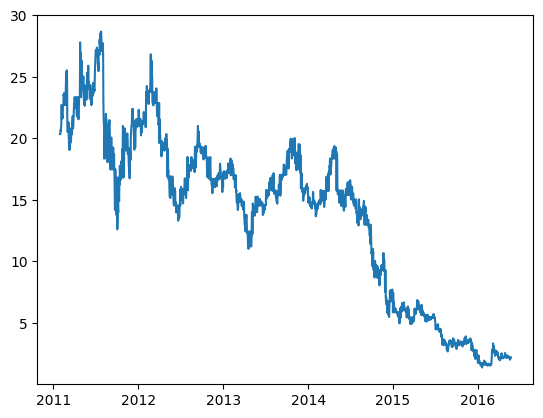

In [369]:
import matplotlib.pyplot as plot
plot.plot(final_data["date"], final_data["wti"])

In [367]:
final_data_path = os.path.join(current_dir, '../data/raw/Dataframe_Final_Data.csv')

final_data.to_csv(final_data_path, index=False)